# Plotting GW memory using sxs

In [65]:
import sxs
import numpy as np
from matplotlib import pyplot as plt

In [2]:
outdir = '../out_gwmem_2022/'

Below is the standard example from the documentation of the `add_memory` function. Very simple. It yields only the $J_E$ term from Mitman et al.

In [3]:
h = sxs.load("SXS:BBH:0305/Lev/rhOverM", extrapolation_order=3) # 0305 corresponds to GW150914
h_with_memory = sxs.waveforms.memory.add_memory(h, integration_start_time=1000.0)

/Users/boris.goncharov/opt/anaconda3/envs/gwmem_sxs/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████████████████████████████████| 73.1M/73.1M [00:06<00:00, 11.7MB/s]


## Displacement memory, $J_E$

## Total contribution to the waveform

A typical illustration of the GW memory effect

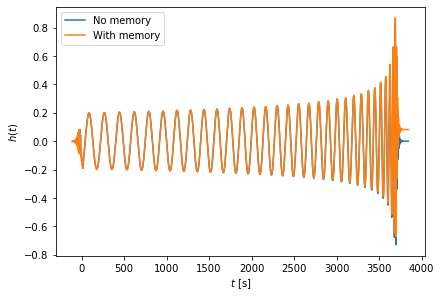

In [66]:
plt.plot(h.t, np.sum(h,axis=1), label='No memory')
plt.plot(h_with_memory.t, np.sum(h_with_memory,axis=1), label='With memory')
plt.tight_layout()
plt.xlabel('$t$ [s]')
plt.ylabel('$h(t)$')
plt.legend()

Only the contribution of GW memory

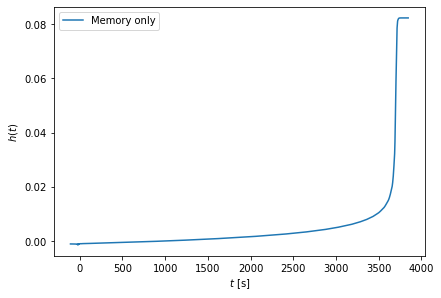

In [69]:
plt.plot(h_with_memory.t, np.sum(h_with_memory,axis=1)-np.sum(h,axis=1), label='Memory only')
plt.tight_layout()
plt.xlabel('$t$ [s]')
plt.ylabel('$h(t)$')
plt.legend()

And all together, zoomed in. Memory contributes only to the final cycles of the inspiral.

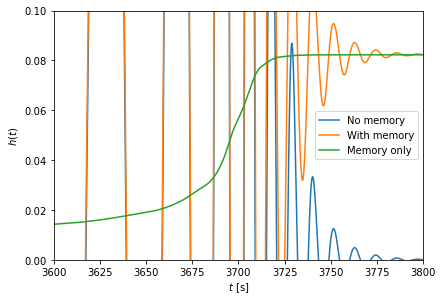

In [71]:
plt.plot(h.t, np.sum(h,axis=1), label='No memory')
plt.plot(h_with_memory.t, np.sum(h_with_memory,axis=1), label='With memory')
plt.plot(h_with_memory.t, np.sum(h_with_memory,axis=1)-np.sum(h,axis=1), label='Memory only')
plt.tight_layout()
plt.xlabel('$t$ [s]')
plt.ylabel('$h(t)$')
plt.xlim([3600, 3800])
plt.ylim([0, 0.1])
plt.legend()

Normalized waveform

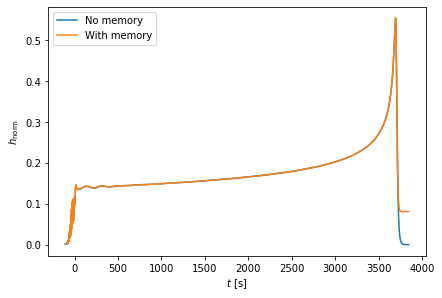

In [67]:
plt.plot(h.t, h.norm, label='No memory')
plt.plot(h_with_memory.t, h_with_memory.norm, label='With memory')
plt.tight_layout()
plt.xlabel('$t$ [s]')
plt.ylabel('$h_\mathrm{norm}$')
plt.legend()

### Spherical harmonic modes

Now, let us consider only $Y(l,m)$ sperical harmonic modes of the waveform. The literature suggests that $(2,0)$ mode represents the major contribution to GW memory, "for non-precessing equal-mass binaries".

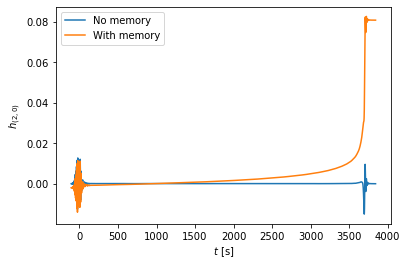

In [78]:
plt.plot(h.t, h["Y_l2_m0.dat"][:,1], label='No memory')
plt.plot(h_with_memory.t, h_with_memory["Y_l2_m0.dat"][:,1], label='With memory')
plt.xlabel('$t$ [s]')
plt.ylabel('$h_{(2,0)}$')
plt.legend()

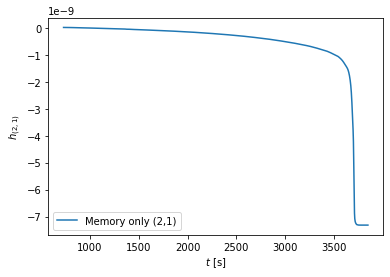

In [89]:
plt.plot(h_with_memory.t[1000:], h_with_memory["Y_l2_m1.dat"][:,1][1000:]-h["Y_l2_m1.dat"][:,1][1000:], 
         label='Memory only (2,1)')
plt.xlabel('$t$ [s]')
plt.ylabel('$h_{(2,1)}$')
plt.legend()

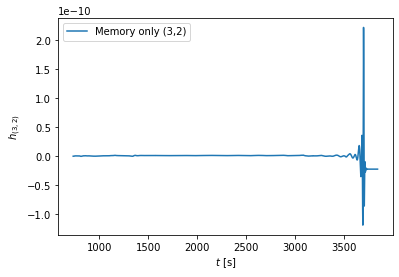

In [90]:
#plt.plot(h.t, h["Y_l3_m2.dat"][:,1], label='No memory')
plt.plot(h_with_memory.t[1000:], h_with_memory["Y_l3_m2.dat"][:,1][1000:]-h["Y_l3_m2.dat"][:,1][1000:], 
         label='Memory only (3,2)')
plt.xlabel('$t$ [s]')
plt.ylabel('$h_{(3,2)}$')
plt.legend()

## Other memory contributions

The three remaining contributions are $J_m$, $J_{\hat{N}}$, and $J_J$. For some reason, they are not included to the function `add_memory`, but the functions to calculate them are written in `sxs.waveforms.memory`. The example for how to add them is adopted from Mike Boyle `https://gist.github.com/moble/819a123a243d77565e9924ab5c664e00`

For this, we need $\Psi_2$. However, only $\Psi_4$ is available the same way as the simulated strain. The list of available data is on Zenodo pages for SXS simulations. For example, this is how to load $\Psi_4$:

In [113]:
psi4 = sxs.load("SXS:BBH:0305/Lev/rMPsi4", extrapolation_order=3) # 0305 corresponds to GW150914

Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rMPsi4_Asymptotic_GeometricUnits_CoM.h5


In Mike's tutorial, $\Psi_2$ is loaded the following way:

In [114]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # To quiet warnings about spin weight not being set
    h = sxs.load("rhOverM_Extrapolated_N5_CoM.h5")
    psi2 = sxs.load("r3Psi2OverM_Extrapolated_N8_CoM.h5")

ValueError: Nothing found matching 'rhOverM_Extrapolated_N5_CoM.h5'

In [101]:
def add_m_memory(h, integration_start_time=None, psi4=None):
    """
    Based entirely on add_memory
    """
    h_memory_correction = sxs.waveforms.memory.J_m(h, integration_start_time=integration_start_time)
    h_with_memory = WaveformModes(MTS(h) + h_memory_correction)
    h_with_memory.register_modification(add_memory, integration_start_time=integration_start_time)
    if psi4 is None:
        return h_with_memory
    else:
        psi4_with_memory = sxs.WaveformModes(sxs.waveforms.memory.MTS(psi4) - sxs.waveforms.memory.MTS(h_memory_correction).ddot)
        psi4_with_memory.register_modification(add_nhat_memory, integration_start_time=integration_start_time)
        return (h_with_memory, psi4_with_memory)

def add_nhat_memory(h, integration_start_time=None, psi4=None):
    """
    Based entirely on add_memory
    """
    h_memory_correction = sxs.waveforms.memory.J_Nhat(h, integration_start_time=integration_start_time)
    h_with_memory = WaveformModes(MTS(h) + h_memory_correction)
    h_with_memory.register_modification(add_memory, integration_start_time=integration_start_time)
    if psi4 is None:
        return h_with_memory
    else:
        psi4_with_memory = sxs.WaveformModes(sxs.waveforms.memory.MTS(psi4) - sxs.waveforms.memory.MTS(h_memory_correction).ddot)
        psi4_with_memory.register_modification(add_nhat_memory, integration_start_time=integration_start_time)
        return (h_with_memory, psi4_with_memory)
    
def add_j_memory(h, integration_start_time=None, psi4=None):
    """
    Based entirely on add_memory
    """
    h_memory_correction = sxs.waveforms.memory.J_J(h)
    h_with_memory = sxs.WaveformModes(sxs.waveforms.memory.MTS(h) + h_memory_correction)
    h_with_memory.register_modification(add_j_memory, integration_start_time=integration_start_time)
    if psi4 is None:
        return h_with_memory
    else:
        psi4_with_memory = sxs.WaveformModes(sxs.waveforms.memory.MTS(psi4) - sxs.waveforms.memory.MTS(h_memory_correction).ddot)
        psi4_with_memory.register_modification(add_j_memory, integration_start_time=integration_start_time)
        return (h_with_memory, psi4_with_memory)

In [115]:
catalog = sxs.load("catalog")

In [103]:
h_with_j_memory = add_j_memory(h, integration_start_time=1000.0)

In [118]:
dir(h)

['LM',
 'Lminus',
 'Lplus',
 'Lsquared',
 'Lz',
 'Rminus',
 'Rplus',
 'Rsquared',
 'Rz',
 'T',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__dlpack__',
 '__dlpack_device__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len_